# PROYECTO CONJUNTO DE DATA SCIENCE

BASE DE DATOS : Brazilian E-Commerce Public Dataset by Olist

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import datetime
import psycopg2

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 0. CREACIÓ D'UNA BASE DE DADES RELACIONAL DE LES DADES

In [ ]:
# Creem una funció per crear la base de dades relacional

def create_dbs():
    try:
        # Ens connectem als servidor 
        conn = psycopg2.connect(
            user = "...", password = "...", host = "localhost", port = "5432"
        )
        conn.set_session(autocommit=True)
        cur = conn.cursor()

        # Creem la base de dades relacional
        cur.execute("DROP DATABASE IF EXISTS test")
        cur.execute(
            "CREATE DATABASE test WITH ENCODING 'utf8' TEMPLATE template0"
        )

        # Tanquem conexió
        conn.close()

        return True
    
    except(Exception, psycopg2.Error) as error:
        print("Error de conexión con la base de datos db: ", error)
        return False
        

In [ ]:
# Creem la base de dades

create_dbs()

In [ ]:
# Definim una funció per connectar-nos amb la base de dades

def get_db(basedatos, contraseña):

    try:
        conn = psycopg2.connect(
            dbname = basedatos, user = "postgres", password = contraseña, host = "localhost", port = "5432"
        )
        
        return conn.cursor(), conn
    except (Exception, psycopg2.Error) as error:
        print("Error de conexión con la base de datos db: ", error)
        return False, False

In [ ]:
# Ens connectem a la base de dades

get_db("...","...")

In [ ]:
# 1
#olist_geolocation_dataset

cdb_geolocation_dataset = ("""
    CREATE TABLE geolocation (
        geolocation_zip_code_prefix int,
        geolocation_lat text,
        geolocation_lng text,
        geolocation_city varchar(255),
        geolocation_state varchar(255),
        geolocation_id int UNIQUE,
        
        PRIMARY KEY (geolocation_id)
    )
""")

In [ ]:
#olist_product_category_name
cdb_product_category_name = ("""
    CREATE TABLE product_category_name (
        product_category_name text,
        product_category_name_english text,
        
        PRIMARY KEY (product_category_name)
    )
""")

In [ ]:
# 2

#olist_customers_dataset

cdb_customers_dataset = ("""
    CREATE TABLE customers (
        customer_id text,
        customer_unique_id text,
        customer_zip_code_prefix int,
        customer_city varchar(255),
        customer_state varchar(255),
        
        PRIMARY KEY (customer_id),
        FOREIGN KEY (customer_zip_code_prefix)
        REFERENCES geolocation (geolocation_id)
    )
""")

In [ ]:
#olist_sellers_dataset

cdb_sellers_dataset = ("""
    CREATE TABLE sellers (
        seller_id text,
        seller_zip_code_prefix int,
        seller_city varchar(255),
        seller_state varchar(255),
        
        PRIMARY KEY (seller_id),
        
        FOREIGN KEY (seller_zip_code_prefix)
        REFERENCES geolocation (geolocation_id)
    )
""")

In [ ]:
#olist_products_datase

cdb_products_dataset = ("""
    CREATE TABLE products (
        product_id text,
        product_category_name varchar(255),
        product_name_length int,
        product_description_length int,
        product_photos_qty int,
        product_weight_g int,
        product_length_cm int,
        product_height_cm int,
        product_width_cm int,
        
        PRIMARY KEY (product_id),
        FOREIGN KEY (product_category_name)
        REFERENCES product_category_name (product_category_name) MATCH SIMPLE
    )
""")

In [ ]:
# 3

#olist_orders_dataset

cdb_orders_dataset = ("""
    CREATE TABLE orders (
        order_id text,
        customer_id text,
        order_status varchar(255),
        order_purchase_timestamp timestamp,
        order_approved_at timestamp,
        order_delivered_carrier_date timestamp,
        order_delivered_customer_date timestamp,
        order_estimated_delivery_date timestamp,
        
        PRIMARY KEY (order_id),
        
        FOREIGN KEY (customer_id)
        REFERENCES customers (customer_id) MATCH SIMPLE
    )
""")

In [ ]:
# 4

#olist_order_items_dataset

cdb_order_items_dataset = ("""
    CREATE TABLE order_items (
        order_item_id int,
        order_id text,
        product_id text,
        seller_id text,
        shipping_limit_date timestamp,
        price float,
        freight_value float,
        
        PRIMARY KEY (order_item_id),
        
        FOREIGN KEY (order_id)
        REFERENCES orders (order_id) MATCH SIMPLE,
        
        FOREIGN KEY (product_id)
        REFERENCES products (product_id) MATCH SIMPLE,
        
        FOREIGN KEY (seller_id)
        REFERENCES sellers (seller_id) MATCH SIMPLE
        
    )
""")

In [ ]:
#olist_order_reviews_dataset

cdb_order_reviews_dataset = ("""
    CREATE TABLE order_reviews (
        review_id text,
        order_id text,
        review_score int,
        review_comment_title text,
        review_comment_message varchar(255),
        review_creation_date timestamp,
        review_answer_timestamp timestamp,
        review_unique_id int,
        
        PRIMARY KEY (review_unique_id),
        
        FOREIGN KEY (order_id)
        REFERENCES orders (order_id) MATCH SIMPLE
    )
""")

In [ ]:
#olist_order_payments_dataset
"""

HABRÁ QUE CREAR UN "ORDER_PAYMENT_ID"

"""
cdb_order_payments_dataset = ("""
    CREATE TABLE order_payments (
        order_id text,
        payment_sequential int,
        payment_type text,
        payment_installments int,
        payment_value text,
        order_payment_id int,
        
        PRIMARY KEY (order_payment_id),
        
        FOREIGN KEY (order_id)
        REFERENCES orders (order_id) MATCH SIMPLE
    )
""")

##### Creem les taules

In [ ]:
# Agrupem les funcions de creació de taules 

cdb = [cdb_geolocation_dataset, cdb_product_category_name, cdb_sellers_dataset, 
       cdb_customers_dataset, cdb_products_dataset, cdb_orders_dataset,
       cdb_order_items_dataset, cdb_order_payments_dataset, cdb_order_reviews_dataset]

In [ ]:
# Connectem amb la base de dades i definim un connector i un cursor. 

cur , conn = get_db("...","...")

In [ ]:
# Creem les taules

for i in cdb:
    cur.execute(i)
    
conn.commit()

##### Carreguem les dades dels csv

In [ ]:
path = "" # path d'on estan allotjades les nostres dades

raw_geolocation_db = pd.read_csv(f"{path}olist_geolocation_dataset.csv")
raw_product_category_name_db = pd.read_csv(f"{path}product_category_name_translation.csv")
raw_sellers_db = pd.read_csv(f"{path}olist_sellers_dataset.csv")
raw_customers_db = pd.read_csv(f"{path}olist_customers_dataset.csv")
raw_products_db = pd.read_csv(f"{path}olist_products_dataset.csv")
raw_orders_db = pd.read_csv(f"{path}olist_orders_dataset.csv")
raw_order_items_db = pd.read_csv(f"{path}olist_order_items_dataset.csv")
raw_order_reviews_db = pd.read_csv(f"{path}olist_order_reviews_dataset.csv")
raw_order_payments_db = pd.read_csv(f"{path}olist_order_payments_dataset.csv")

##### Modifiquem els csv de "order_payments" i "geolocation" afegint una nova columna que fagi d'ID.

In [ ]:
# order_payments
raw_order_payments_db["order_payments_id"] = raw_order_payments_db.index
raw_order_payments_db.head()

In [ ]:
# geolocation
raw_geolocation_db["geolocation_id"] = raw_geolocation_db.index
raw_geolocation_db.head()

##### Creem els inserts mitjançant els quals insertarem les dades a la nostra base de dades.

In [ ]:
insert_geolocation = ("""
    INSERT INTO geolocation (
        geolocation_zip_code_prefix,
        geolocation_lat,
        geolocation_lng,
        geolocation_city,
        geolocation_state,
        geolocation_id
    )
    VALUES(%s, %s, %s, %s, %s, %s)
""")

In [ ]:
insert_product_category_name = ("""
    INSERT INTO product_category_name (
        product_category_name,
        product_category_name_english
    )
    VALUES(%s, %s)
""")

In [ ]:
insert_customers = ("""
    INSERT INTO customers (
        customer_id,
        customer_unique_id,
        customer_zip_code_prefix,
        customer_city,
        customer_state
    )
    VALUES(%s,%s,%s,%s,%s)
""")

In [ ]:
insert_sellers = ("""
    INSERT INTO sellers (
        seller_id,
        seller_zip_code_prefix,
        seller_city,
        seller_state
    )
    VALUES(%s,%s,%s,%s)
""")

In [ ]:
insert_products = ("""
    INSERT INTO products (
        product_id,
        product_category_name,
        product_name_length,
        product_description_length,
        product_photos_qty,
        product_weight_g,
        product_length_cm,
        product_height_cm,
        product_width_cm
    )
    VALUES(%s,%s,%s,%s,%s,%s,%s,%s,%s)
""")

In [ ]:
insert_orders = ("""
    INSERT INTO orders (
        order_id,
        customer_id,
        order_status,
        order_purchase_timestamp,
        order_approved_at,
        order_delivered_carrier_date,
        order_delivered_customer_date,
        order_estimated_delivery_date
    )
    VALUES(%s,%s,%s,%s,%s,%s,%s,%s)
""")

In [ ]:
insert_order_items = ("""
    INSERT INTO order_items (
        order_item_id,
        order_id,
        product_id,
        seller_id,
        shipping_limit_date,
        price,
        freight_value
    )
    VALUES(%s,%s,%s,%s,%s,%s,%s)
""")

In [ ]:
insert_order_reviews = ("""
    INSERT INTO order_reviews (
        review_id,
        order_id,
        review_score,
        review_comment_title,
        review_comment_message,
        review_creation_date,
        review_answer_timestamp,
        review_unique_id
    )
    VALUES(%s,%s,%s,%s,%s,%s,%s,%s)
""")

In [ ]:
insert_order_payments = ("""
    INSERT INTO order_payments (
        order_id,
        payment_sequential,
        payment_type,
        payment_installments,
        payment_value,
        order_payment_id
    )
    VALUES(%s,%s,%s,%s,%s,%s)
""")

##### Executem els inserts

In [ ]:
# Creem la llista amb els inserts a realitzar

insertasiones = [insert_geolocation, insert_product_category_name, insert_sellers, insert_customers, 
                insert_products, insert_orders, insert_order_items, insert_order_payments, insert_order_reviews]

In [ ]:
# Llista dels csv

datas = [raw_geolocation_db,raw_product_category_name_db,raw_sellers_db,raw_customers_db,
        raw_products_db,raw_orders_db,raw_order_items_db,raw_order_payments_db, raw_order_reviews_db]

In [ ]:
# Bucle per afegir totes les dades a la nostra base de dades

for i in range(len(insertasiones)):
    for e in range(len(datas[i])):
        row = datas[i][:].values[e]
        cur.execute(insertasiones[i], row)
        conn.commit()
    

### 1. Incloure el conjunt de dades

In [86]:

customers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_customers_dataset.csv',dtype={'customer_zip_code_prefix': str})
geolocation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_geolocation_dataset.csv',dtype={'geolocation_zip_code_prefix': str})
order_items = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_orders_dataset.csv')
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_products_dataset.csv')
sellers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/olist_sellers_dataset.csv',dtype={'seller_zip_code_prefix': str})
product_category_name_translation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/product_category_name_translation.csv')

In [87]:
#####################################################################################################################################################################################################

In [88]:
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,01037,-23.545621,-46.639292,sao paulo,SP
1,01046,-23.546081,-46.644820,sao paulo,SP
2,01046,-23.546129,-46.642951,sao paulo,SP
3,01041,-23.544392,-46.639499,sao paulo,SP
4,01035,-23.541578,-46.641607,sao paulo,SP


In [89]:
#ZIP code aggregation
geo_group=geolocation.groupby('geolocation_zip_code_prefix').mean()
geo_group.head()

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
01001,-23.550190,-46.634024
01002,-23.548146,-46.634979
01003,-23.548994,-46.635731
01004,-23.549799,-46.634757
01005,-23.549456,-46.636733


In [90]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [91]:
customers2=pd.merge(customers, geo_group[['geolocation_lat','geolocation_lng']], how='left',
                    left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')\
                    .rename(columns={"geolocation_lat" : "customers_lat" , "geolocation_lng" : "customers_lng"})

In [92]:
customers2

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customers_lat,customers_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.498489,-47.396929
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP,-23.727992,-46.542848
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP,-23.531642,-46.656289
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP,-23.499702,-46.185233
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,-22.975100,-47.142925
...,...,...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,03937,sao paulo,SP,-23.586003,-46.499638
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,06764,taboao da serra,SP,-23.615830,-46.768533
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE,-3.734569,-38.510534
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS,-29.949839,-51.168494


In [93]:
sellers2=pd.merge(sellers, geo_group[['geolocation_lat','geolocation_lng']], how='left',
                    left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')\
                    .rename(columns={"geolocation_lat" : "sellers_lat" , "geolocation_lng" : "sellers_lng"})

In [94]:
sellers2

,seller_id,seller_zip_code_prefix,seller_city,seller_state,sellers_lat,sellers_lng
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,-22.893848,-47.061337
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,-22.383437,-46.947927
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,-22.909572,-43.177703
3,c0f3eea2e14555b6faeea3dd58c1b1c3,04195,sao paulo,SP,-23.657242,-46.612831
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,-22.964803,-46.534419
...,...,...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR,-23.448041,-51.869960
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC,-27.656421,-48.665840
3092,74871d19219c7d518d0090283e03c137,04650,sao paulo,SP,-23.657851,-46.676925
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,-31.751072,-52.323202


In [95]:
order_reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [96]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [97]:
#Crear un df amb les dades de tots els df anteriors

olist = orders.merge(order_items, on='order_id', how='left')
olist = olist.merge(order_payments, on='order_id', how='outer', validate='m:m')
#olist = olist.merge(order_reviews, on='order_id', how='outer')
olist = olist.merge(products, on='product_id', how='outer')
olist = olist.merge(customers2, on='customer_id', how='outer')
olist = olist.merge(sellers2, on='seller_id', how='outer')

In [98]:
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_zip_code_prefix,customer_city,customer_state,customers_lat,customers_lng,seller_zip_code_prefix,seller_city,seller_state,sellers_lat,sellers_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,03149,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,03366,sao paulo,SP,-23.564630,-46.534268,09350,maua,SP,-23.680729,-46.444238
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,02290,sao paulo,SP,-23.600462,-46.655318,09350,maua,SP,-23.680729,-46.444238


In [99]:
#veure l'estat de les orders

olist.order_status.value_counts()

delivered      115038
shipped          1245
canceled          745
unavailable       650
processing        375
invoiced          373
created             5
approved            3
Name: order_status, dtype: int64

In [100]:
#Analitzar només les comandes entregades

olist2 = olist[olist.order_status=='delivered']

In [101]:
olist2.order_status.value_counts()

delivered    115038
Name: order_status, dtype: int64

#### 2. Comprovar si hi ha observacions de NaN i decidir què fem amb ells 

In [102]:
olist2.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_category_name            1628
product_name_lenght              1628
product_description_lenght       1628
product_photos_qty               1628
product_weight_g                   20
product_length_cm                  20
product_height_cm                  20
product_width_cm                   20
customer_uni

In [103]:
olist3=olist2.drop(columns=['product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty'])

In [104]:
percent_missing = olist3.isnull().sum() * 100 / len(olist3)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,percent_missing
customers_lng,0.259045
customers_lat,0.259045
sellers_lng,0.223404
sellers_lat,0.223404
product_width_cm,0.017386
product_height_cm,0.017386
product_length_cm,0.017386
product_weight_g,0.017386
order_approved_at,0.013039
order_delivered_customer_date,0.006954


In [105]:
olist4=olist3.dropna(axis=0,how="any")
print(f"Length of before dropping:\t{len(olist3):>1}")
print(f"Length of after dropping:\t{len(olist4):>1}")

Length of before dropping:	115038
Length of after dropping:	114437


### 3. Feature engineering

In [106]:
#Calcular la distància entre seller i costumer
from math import radians, sin, cos, asin, sqrt


In [107]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Compute distance between two pairs of (lat, lng)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    return 2 * 6371 * asin(sqrt(a))
  
olist4['distance'] = olist4.apply(
    lambda row: haversine_distance(
        row['sellers_lat'],
        row['sellers_lng'],
        row['customers_lat'],
        row['customers_lng'],
        ),
        axis=1,
    ) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [108]:
olist4.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,customer_city,customer_state,customers_lat,customers_lng,seller_zip_code_prefix,seller_city,seller_state,sellers_lat,sellers_lng,distance
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238,18.576110
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238,18.576110
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,-23.576983,-46.587161,09350,maua,SP,-23.680729,-46.444238,18.576110
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,-23.564630,-46.534268,09350,maua,SP,-23.680729,-46.444238,15.836181
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,...,sao paulo,SP,-23.600462,-46.655318,09350,maua,SP,-23.680729,-46.444238,23.280158


In [109]:
#Convertir les columnes amb dates a datetime i calcular les noves columnes per day of week i day of year

import datetime

In [110]:
olist4['purchase_wd']= pd.to_datetime(olist4.order_purchase_timestamp).dt.day_of_week
olist4['purchase_yd'] = pd.to_datetime(olist4.order_purchase_timestamp).dt.day_of_year

olist4['approved_wd']= pd.to_datetime(olist4.order_approved_at).dt.day_of_week
olist4['approved_yd'] = pd.to_datetime(olist4.order_approved_at).dt.day_of_year

olist4['carrier_wd']= pd.to_datetime(olist4.order_delivered_carrier_date).dt.day_of_week
olist4['carrier_yd'] = pd.to_datetime(olist4.order_delivered_carrier_date).dt.day_of_year

olist4.order_estimated_delivery_date = pd.to_datetime(olist4.order_estimated_delivery_date)
olist4.order_delivered_customer_date = pd.to_datetime(olist4.order_delivered_customer_date)

olist4.shipping_limit_date = pd.to_datetime(olist4.shipping_limit_date)
#olist4.review_answer_timestamp = pd.to_datetime(olist4.review_answer_timestamp)
#olist4.review_creation_date = pd.to_datetime(olist4.review_creation_date)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [111]:
olist4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114437 entries, 0 to 118433
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       114437 non-null  object        
 1   customer_id                    114437 non-null  object        
 2   order_status                   114437 non-null  object        
 3   order_purchase_timestamp       114437 non-null  object        
 4   order_approved_at              114437 non-null  object        
 5   order_delivered_carrier_date   114437 non-null  object        
 6   order_delivered_customer_date  114437 non-null  datetime64[ns]
 7   order_estimated_delivery_date  114437 non-null  datetime64[ns]
 8   order_item_id                  114437 non-null  float64       
 9   product_id                     114437 non-null  object        
 10  seller_id                      114437 non-null  object        
 11  

In [112]:
#Càlcul de la diferència entre data efectiva d'entrega i data d'entrega estimada 

olist4['delay']=(olist4['order_estimated_delivery_date']-olist4['order_delivered_customer_date']).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [113]:
#Calculem el volum dels productes

olist4['product_volume_cm3']=olist4['product_width_cm']*olist4['product_length_cm'] *olist4['product_height_cm']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
#Eliminem els valors de dimensions individuals 

olist5 = olist4.drop(columns=['product_height_cm','product_width_cm','product_length_cm'])

In [115]:
olist5.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,sellers_lng,distance,purchase_wd,purchase_yd,approved_wd,approved_yd,carrier_wd,carrier_yd,delay,product_volume_cm3
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,-46.444238,18.576110,0,275,0,275,2,277,7,1976.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,-46.444238,18.576110,0,275,0,275,2,277,7,1976.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,...,-46.444238,18.576110,0,275,0,275,2,277,7,1976.0
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28,1.0,87285b34884572647811a353c7ac498a,...,-46.444238,15.836181,1,227,1,227,3,229,9,1976.0
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15,1.0,87285b34884572647811a353c7ac498a,...,-46.444238,23.280158,2,214,2,214,4,216,7,1976.0


### 4. Exploratory Data Analysis (EDA)

In [116]:
#Representació en un mapa de la localització de customers i sellers
import json

In [117]:
#Carreguem json amb les dades geogràfiques de Brasil
geojson = json.load(open('/content/drive/MyDrive/Colab Notebooks/Projecte final/Data/brazil_geo.json'))

FileNotFoundError: ignored

In [ ]:
sc = olist5.groupby('seller_state')['seller_id'].count().to_frame()
sc = sc.rename(columns={'seller_id':'seller_count'})

cc = olist5.groupby('customer_state')['customer_id'].count().to_frame()
cc = cc.rename(columns={'customer_id':'customer_count'})

dc = olist5.groupby('customer_state')['delay'].mean().to_frame()
dc = dc.rename(columns={'delay':'delay_mean'})

dc.head()

In [ ]:
#Creem un df amb les dades de nombre de customers, sellers y delay per cada estat
geo_analysis = pd.merge(sc, cc,left_index=True,right_index=True,how='left') 
geo_analysis = pd.merge(geo_analysis, dc, left_index=True, right_index=True, how='left')

geo_analysis.head()

In [ ]:
#Funció per representar les variables del df anterior en un mapa de Brasil

def plot_state_choropleth_map(data_frame, locations, geojson, color, color_continuous_scale='sunset',height=700,width=600):
    fig = px.choropleth(data_frame=data_frame, locations=locations, geojson=geojson, color=color, color_continuous_scale=color_continuous_scale, scope="south america")
    fig.update_layout(height=height, width=width,
                  title=f"<b>Brazilian E-Commerce Geolocation for {color}</b>",
                  geo=dict(lonaxis = dict(range= [-33.0, -80.0]),lataxis = dict(range= [5.0, -35.0])))
    fig.show()

In [ ]:
plot_state_choropleth_map(data_frame=geo_analysis, locations=geo_analysis.index, geojson=geojson, color="seller_count")

In [ ]:

plot_state_choropleth_map(data_frame=geo_analysis, locations=geo_analysis.index, geojson=geojson, color="customer_count")

In [ ]:
def plot_state_choropleth_map2(data_frame, locations, geojson, color, color_continuous_scale='viridis',height=700,width=600):
    fig = px.choropleth(data_frame=data_frame, locations=locations, geojson=geojson, color=color, color_continuous_scale=color_continuous_scale, scope="south america")
    fig.update_layout(height=height, width=width,
                  title=f"<b>Brazilian E-Commerce Geolocation for {color}</b>",
                  geo=dict(lonaxis = dict(range= [-33.0, -80.0]),lataxis = dict(range= [5.0, -35.0])))
    fig.show()
plot_state_choropleth_map2(data_frame=geo_analysis, locations=geo_analysis.index, geojson=geojson, color="delay_mean")

In [ ]:
#Calculem el ratio de delayed orders per cada estat
tmp = olist5[['customer_state','order_delivered_customer_date','order_estimated_delivery_date']]
tmp['is_delayed'] = tmp['order_delivered_customer_date'] > tmp['order_estimated_delivery_date']
is_delayed = tmp.groupby('customer_state')['is_delayed'].sum()/tmp.groupby('customer_state')['is_delayed'].count()
is_delayed.head()

In [ ]:
#Creem el df de delay_ratio per representar-ho en un mapa

delays=pd.merge(is_delayed, tmp,left_index=True,right_index=True,how='left') 
delays=delays.rename(columns={'is_delayed_x':'delay_ratio'}).drop(columns=['customer_state','order_delivered_customer_date','order_estimated_delivery_date','is_delayed_y'])

In [ ]:
delays.head()

In [ ]:
plot_state_choropleth_map(data_frame=delays, locations=delays.index, geojson=geojson, color="delay_ratio")

In [ ]:
# Creem diferents df calculant el número de comandes per día de la setmana/any per les diferents dates analitzades: purchase, approved and carrier date 

purchase_wday = olist5.groupby('purchase_wd')['order_id'].count().to_frame()
purchase_wday = purchase_wday.rename(columns={'order_id':'order_count'})

purchase_yday = olist5.groupby('purchase_yd')['order_id'].count().to_frame()
purchase_yday = purchase_yday.rename(columns={'order_id':'order_count'})

approved_wday = olist5.groupby('approved_wd')['order_id'].count().to_frame()
approved_wday = approved_wday.rename(columns={'order_id':'order_count'})

approved_yday= olist5.groupby('approved_yd')['order_id'].count().to_frame()
approved_yday = approved_yday.rename(columns={'order_id':'order_count'})

carrier_wday = olist5.groupby('carrier_wd')['order_id'].count().to_frame()
carrier_wday = carrier_wday.rename(columns={'order_id':'order_count'})

carrier_yday= olist5.groupby('carrier_yd')['order_id'].count().to_frame()
carrier_yday = carrier_yday.rename(columns={'order_id':'order_count'})

purchase_yday.head()

In [ ]:
#Representació de las diferents variables amb histogrames

sns.set_theme(style="whitegrid")
#sns.boxplot(x="purchase_wd", data=olist3)
#tips = sns.load_dataset("olist3")
#ax = sns.boxplot(x=tips["purchase_wd"])
sns.color_palette("tab10")

sns.histplot(data=olist5, x="purchase_wd", binwidth=0.9).set(title='Purchase day of the week')


In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
trace1 = go.Histogram(x=olist5['purchase_wd'])

In [ ]:
fig = make_subplots(rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Purchase date", "Approved date", "Delivered to carrier date"))

trace1 = go.Histogram(x=olist5['purchase_wd'])
trace2 = go.Histogram(x=olist5['approved_wd'])
trace3 = go.Histogram(x=olist5['carrier_wd'])

fig.append_trace(trace1, row=1, col=1)

fig.append_trace(trace2, row=1, col=2)

fig.append_trace(trace3, row=1, col=3)

fig.update_layout(height=600, width=800, title_text="Day of the week subplots", bargap=0.2, showlegend=False)
fig.show()

In [ ]:
fig2 = make_subplots(rows=1, cols=3, shared_yaxes=True,
    subplot_titles=("Purchase date", "Approved date", "Delivered to carrier date"))

trace1 = go.Histogram(x=olist5['purchase_yd'])
trace2 = go.Histogram(x=olist5['approved_yd'])
trace3 = go.Histogram(x=olist5['carrier_yd'])

fig2.append_trace(trace1, row=1, col=1)

fig2.append_trace(trace2, row=1, col=2)

fig2.append_trace(trace3, row=1, col=3)

fig2.update_layout(height=600, width=1200, title_text="Day of the week subplots", bargap=0.2, showlegend=False)
fig2.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

N = len(olist4)
x = olist4['product_volume_cm3']/1000
y = olist4['delay']
colors = np.random.rand(N)
area = 5
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.xlabel("Package volume (L)")
plt.ylabel("Delay days")
plt.figure(figsize=(10,10), dpi=100)
plt.show()

### 5. Machine learning

#### **TÈCNIQUES DE REGRESSIÓ**



LINEAR REGRESSION

In [119]:
# Redefinim el nostre conjunt de dades per només dirigir la nostra atenció a aquelles variables que poden tenir alguna cosa a veure amb el "delay"

columns = ['freight_value','product_weight_g','product_volume_cm3', 'distance', 'purchase_wd', 
           'purchase_yd', 'approved_wd','approved_yd', 'carrier_wd', 'carrier_yd', 'delay']

olist5 = olist5[columns]
olist5.head()

,freight_value,product_weight_g,product_volume_cm3,distance,purchase_wd,purchase_yd,approved_wd,approved_yd,carrier_wd,carrier_yd,delay
0,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,7
1,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,7
2,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,7
3,7.78,500.0,1976.0,15.836181,1,227,1,227,3,229,9
4,7.78,500.0,1976.0,23.280158,2,214,2,214,4,216,7


In [120]:
# Definim les nostres X i y 

X = olist5.drop(columns=['delay'])

y = olist5['delay']

In [121]:
# Normalitzem les nostres dades

X_norm=StandardScaler().fit_transform(X)

In [122]:
# Separem les dades per poder entrenar el model amb el 80% de les dades i poguem validar el model amb el 20% de les dades restants

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)

In [123]:
# Definim la regressió que volem fer i fem un fit del model amb les dades de trainning

regressor = LinearRegression()

regressor.fit(X_train, y_train)

# Visualitzem els coeficients del nostre model
regressor.coef_

array([ 0.34304195, -0.22080427, -0.07694123,  0.65940687,  0.32824651,
        1.12261162, -0.04716069, -1.2001582 , -0.13902537, -0.26611874])

In [124]:
# Predim els valors de y sobre el nostre conjunt de "test" amb el nostre model de regressió lineal

y_pred = regressor.predict(X_test)

In [125]:
# Mirem la variabilitat explicada del nostre model 

regressor.score(X_test, y_test)

0.007986580773532759

In [126]:
# Veiem la matriu de correlacions

#olist5.corr()
fig = px.imshow(olist5.corr())
fig.show()

STOCHASTIC GRADIENT DESCENT REGRESSION

In [127]:
# Definim el model i fem el fit amb les dades de "train"

clf = SGDRegressor(loss="squared_error")

clf.fit(X_train, y_train)

#Mirem els coeficients

clf.coef_

array([ 0.33962524, -0.06971829, -0.14540383,  0.7518888 ,  0.3338588 ,
        0.86219856, -0.12270598, -1.07839709, -0.19340311, -0.18167703])

In [128]:
# Calculem els valors de y amb el model estocastic

y_pred=clf.predict(X_test)

In [129]:
# Mirem la variabilitat explicada pel model 

clf.score(X_test,y_test)

0.007711534058900349

RIDGE REGRESSION

In [130]:
# Apliquem el model de Ridge a les nostres dades

ridge = linear_model.Ridge(alpha=.5)

ridge.fit(X_train,y_train)

# Coeficients
ridge.coef_

array([ 0.34303897, -0.22080061, -0.0769414 ,  0.65940368,  0.32824859,
        1.12072191, -0.04716206, -1.19820514, -0.13902455, -0.26618448])

In [131]:
# Calculem els valors de y i calculem a variabilitat explicada pel model

y_pred=ridge.predict(X_test)

ridge.score(X_test,y_test)

0.0079867255774273

MLP REGRESSOR

In [132]:
# Apliquem el model 

mlp_regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [133]:
# Calculem valors de la y i mirem la score del nostre model

mlp_regr.predict(X_test[:])
mlp_regr.score(X_test,y_test)

0.1400870389414849

RANDOM FORESTS

In [134]:
# Apliquem el model i calculem els coeficients

rf_regr = RandomForestRegressor(max_depth=2, random_state=0)
rf_regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, random_state=0)

In [135]:
# Calculem valors de y i calculem el score

rf_regr.predict(X_test)
rf_regr.score(X_test,y_test)

0.025995038551967053

#### **TÈCNIQUES DE CLASSIFICACIÓ**

TRANSFORMACIÓ DE LA VARIABLE "DELAY" A UNA VARIABLE BOOLEANA

In [136]:
# Copiem el df
olist6 = olist5.copy()

# Creem la nova variable i eliminem la antiga
olist6["is_delay"] = olist6["delay"] < 0
olist6.drop("delay", axis = 1, inplace = True)

olist6.head()

,freight_value,product_weight_g,product_volume_cm3,distance,purchase_wd,purchase_yd,approved_wd,approved_yd,carrier_wd,carrier_yd,is_delay
0,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,False
1,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,False
2,8.72,500.0,1976.0,18.576110,0,275,0,275,2,277,False
3,7.78,500.0,1976.0,15.836181,1,227,1,227,3,229,False
4,7.78,500.0,1976.0,23.280158,2,214,2,214,4,216,False


SGD CLASSIFIER

In [137]:
# Definim les noves variables de treball

X = olist6.drop("is_delay", axis = 1)
y = olist6["is_delay"]


# Normalitzem

X_norm=StandardScaler().fit_transform(X)


# Separem entre train i test

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2)

In [138]:
# Apliquem la tècnica de classificació SGD

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3)

sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [139]:
# Calculem valors de la y i la score

y_pred = sgd_clf.predict(X_test)

sgd_clf.score(X_test,y_test)

0.9210503320517301

In [140]:
# Mirem la f1_score
f1_score(y_test, y_pred, average = None)

array([0.95890286, 0.        ])

In [141]:
# Mirem la matriu de confusió

confusion_matrix(y_test, y_pred)

array([[21081,     0],
       [ 1807,     0]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



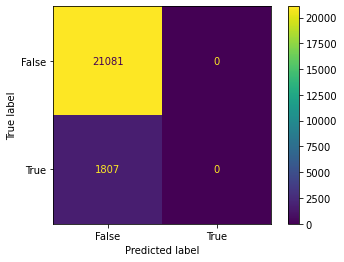

In [142]:
plot_confusion_matrix(sgd_clf,X_test,y_test)

ISOLATION FOREST

In [143]:
# Apliquem el model i fem el fit. també calculem les y

if_clf = IsolationForest(random_state=0).fit(X_train)

y_pred = if_clf.predict(X_test)

In [144]:
# Mirem quants -1 i 1 s'han generat

np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([ 4978, 17910]))

In [145]:
# Creem un df nou per veure si les nostres y i les predites coincideixen

data_marcos = pd.DataFrame(X_test)

data_marcos["y_test"] = y_test.values
data_marcos["y_pred"] = y_pred

((data_marcos["y_test"]== True) & (data_marcos["y_pred"] == -1)).mean()

0.020840615169521147

In [146]:
confusion_matrix(y_test,y_pred)

array([[    0,     0,     0],
       [ 4501,     0, 16580],
       [  477,     0,  1330]])

OVERSAMPLING: SMOTE

In [147]:
# Apliquem el model i creem noves dades de trainning únicament
oversample = SMOTE()
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)

In [148]:
# Entrenem el model

sgd_clf.fit(X_train_os, y_train_os)

SGDClassifier()

In [149]:
# Calculem les y i la score

y_pred = sgd_clf.predict(X_test)
sgd_clf.score(X_test, y_test)

0.7720639636490737

In [150]:
# Mirem la f1
f1_score(y_test,y_pred)

0.15074068044929187

In [151]:
# Mirem la matriu de confusió
confusion_matrix(y_test, y_pred)


array([[17208,  3873],
       [ 1344,   463]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



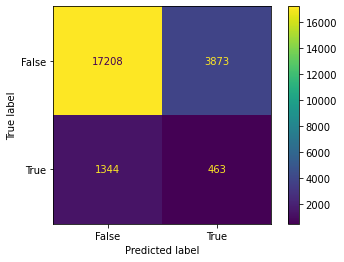

In [152]:
plot_confusion_matrix(sgd_clf,X_test,y_test)

GRID SEARCH: RANDOMIZED

In [153]:
# Apliquem el model de classificació

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, 
                              random_state=0, class_weight = "balanced")

distributions = dict(C=np.logspace(-5, 5, num=10), penalty=['l2', 'l1'])

grid_clf = RandomizedSearchCV(logistic, distributions, random_state=0, scoring = "f1")
search = grid_clf.fit(X_train, y_train)

In [162]:
# Visualitzem la millor score obtinguda i el millor index
search.best_score_ , search.best_index_ , search.best_params_

(0.17001276014934888, 9, {'C': 0.0001291549665014884, 'penalty': 'l2'})

In [155]:
# Mirem la matriu de confusió
confusion_matrix(y_test,search.best_estimator_.predict(X_test))

array([[13662,  7419],
       [  973,   834]])

In [156]:
# Mirem la f1 score
f1_score(y_test,search.best_estimator_.predict(X_test))

0.1658051689860835

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



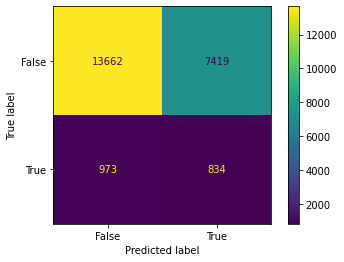

In [157]:
# Mirem les matrius de confusió juntes i amb colors per visualitzar-les millor

plot_confusion_matrix(grid_clf, X_test, y_test)

APLIQUEM UN MODEL POLINOMIAL AL GRIDSEARCH PER MILLORAR LA OPTIMITZACIÓ DEL MODEL DE CLASSIFICACIÓ

In [158]:
# Canviem el model de classificació aplicant-li una optimització polinomial mitjançant una pipeline

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200, random_state=0, class_weight = "balanced")
distributions = dict(C=np.logspace(-5, 5, num=10), penalty=['l2', 'l1'])

# Definim el model
pipe_clf = make_pipeline(PolynomialFeatures(2), RandomizedSearchCV(logistic, distributions, random_state=0, scoring = "f1"))

pipe_search = pipe_clf.fit(X_train, y_train)

In [159]:
# Mirem el score del nostre model

pipe_search.score(X_test, y_test)

0.1914338919925512

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



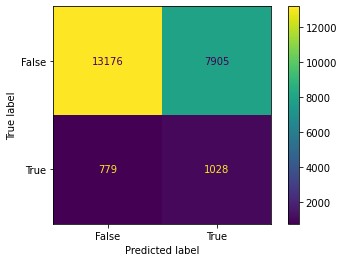

In [160]:
plot_confusion_matrix(pipe_clf,X_test,y_test)

In [161]:
np.array([[13062,8086],[673,1067]])

array([[13062,  8086],
       [  673,  1067]])